In [1]:
!pip install tensorflow==2.2.0
!pip install gpflow
!pip install gast
!pip install observations

     |████████████████████████████████| 235kB 4.5MB/s 
     |████████████████████████████████| 491kB 4.9MB/s 
  Created wheel for observations: filename=observations-0.1.4-cp36-none-any.whl size=1319270 sha256=5830f8f00adda52cc0b37b589b0a803c6af071838ad333dcd074115d4b70eb65
  Stored in directory: /root/.cache/pip/wheels/21/53/d7/c4d7a5cab86d07b083ebb2e417dcd0cb2bf5dd8c440af675d7
Successfully built observations


In [2]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.covariances import Kuu
from gpflow.covariances import Kuf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

import VFF_IV

helloworld


Make `tensorboard` work inside notebook:

In [0]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [0]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [0]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [6]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

>> Downloading ./SPGP_dist.zip.part 
>> [14.7 KB/14.7 KB] 6944% @2.5 MB/s,[0s remaining, 0s elapsed]        
URL http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip downloaded to ./SPGP_dist.zip 


Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


In [0]:
from gpflow.conditionals import conditional

def plot(Xtest, models):

  for (mean, std, meanColour, stdColour) in models:
    plt.plot(Xtest, mean, color=meanColour)

    plt.plot(Xtest, mean + std, color=stdColour)
    plt.plot(Xtest, mean - std, color=stdColour)
    plt.fill_between(np.squeeze(Xtest), np.squeeze(mean + std), np.squeeze(mean - std), color=stdColour, alpha=0.2)
  

  plt.scatter(X, Y, s=15)

  plt.show()



## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

In [0]:
class RVFF_1D(gpflow.inducing_variables.InducingVariables):
    def __init__(self, a, b, M):
        self.length = M
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

        self.phis = gpflow.Parameter(np.random.uniform(0, 2 * np.pi, size=M))
        self.omegas = gpflow.Parameter(np.random.uniform(0, 0.5 * M, size=M))

    def __len__(self):
        """ number of inducing variables (defines dimensionality of q(u)) """ 
        return self.length  # M sine components

In [0]:
@cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
    a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
    lambda_ = 1.0 / kernel.lengthscales
    
    def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
      angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle5 = omegas * ( 2 * intervalLen + phis[:, None] + phis[None, :] )
      angle6 = omegas * (phis[:, None] + phis[None, :])

      denom1 = tf.Variable(omegas[:, None] - omegas[None, :])
      denom2 = tf.Variable(omegas[:, None] + omegas[None, :])
      denom3 = tf.Variable(2 * omegas)

      denom1 = tf.where(denom1 == 0, 1.0, denom1)
      denom2 = tf.where(denom2 == 0, 1.0, denom2)
      denom3 = tf.where(denom3 == 0, 1.0, denom3)
      
      coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / denom1 
      coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / denom2 #( omegas[:, None] + omegas[None, :] )
      coeff3 = ( omegas * omegas - lambda_ * lambda_ ) / denom3
      coeff4 = -coeff3
      coeff5 = lambda_ * lambda_ + omegas * omegas

      denom = 4  * kernelVar * lambda_

      firstTerm = ( coeff1 * tf.sin( angle1 ) +
                    coeff2 * tf.sin( angle2 ) -
                    lambda_ * tf.cos( angle2 ) +
                    lambda_ * tf.cos( angle1 ) -
                    coeff1 * tf.sin( angle3 ) -
                    coeff2 * tf.sin( angle4 ) +
                    lambda_ * tf.cos( angle4 ) -
                    lambda_ * tf.cos( angle3 ) ) / denom

      firstTermForEqualOmegas = ( ( omegas * omegas + lambda_ * lambda_ ) * tf.cos(omegas * (phis[:, None] - phis[None, :]) ) * intervalLen + 
                                coeff3 * tf.sin( angle5 ) -
                                ( lambda_ * tf.cos( angle5 ) ) -
                                ( coeff3 * tf.sin( angle6 ) ) +
                                lambda_ * tf.cos( angle6 ) ) / denom

      firstTermForZeroOmegas = tf.reshape(tf.Variable(intervalLen * lambda_ / kernelVar / 2), shape=(-1))

      firstTerm = tf.where( denom1 == 1.0, firstTermForEqualOmegas, firstTerm )
      firstTerm = tf.where( denom3 == 1.0, 0.0, firstTerm )
      firstTerm = tf.where( denom2 == 1.0, firstTermForZeroOmegas, firstTerm )

      # firstTermForOppositeOmegas = ( coeff4 * tf.sin( angle5 ) -
      #                                coeff5 * tf.cos( omegas * (phis[:, None] - phis[None, :]) ) * intervalLen +
      #                                lambda_ * tf.cos( angle5 ) -
      #                                coeff4 * tf.sin( angle6 ) -
      #                                lambda_ * tf.cos( angle6 ) ) / denom

      # for index in zerosIn1:
      #   firstTerm[index[0], index[1]].assign( firstTermForEqualOmegas[index[0], index[1]] )

      # for index in zerosIn2:
      #   firstTerm[index[0], index[1]].assign( firstTermForOppositeOmegas[index[0], index[1]] )

      # if not tf.equal(tf.size(zerosIn3), 0): # if not empty
      #   for index in list(zerosIn3[0].numpy()):
      #     firstTerm[index, index].assign( firstTermForZeroOmegas[index] )

      # firstTerm = tf.linalg.set_diag( firstTerm, tf.linalg.tensor_diag_part(firstTermForEqualOmegas) )
      
      # secondTerm = tf.sin( omegas[:, None] * phis[:, None] ) * tf.sin( omegas[None, :] * phis[None, :] ) / ( kernelVar )
      secondTermfactors = tf.where( denom3 != 1.0, tf.sin( omegas * phis ), tf.sin( phis ) )

      secondTerm = secondTermfactors[:, None] * secondTermfactors[None, :] / kernelVar

      res = firstTerm + secondTerm
      res = 0.5 * (res + tf.transpose(res))

      if jitter != None:
        res = res + tf.cast(tf.linalg.diag( jitter * tf.ones( res.shape[0] ) ), default_float())
    
      return res

    return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

@cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    
    nonZeroOmegas = tf.sin( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )
    phis = tf.tile(tf.reshape(phis, (-1,1)), [1, len(X)])
    omegas = tf.tile(tf.reshape(omegas, (-1,1)), [1, len(X)])
    zeroOmegas = tf.sin( phis )

    res = tf.where( omegas != 0, nonZeroOmegas, zeroOmegas )
    
    return res

#Model Definition:

###We use exact inference first

0
kernel lengthscale: 0.50
kernel variance: 0.50
Exact model log p(y): -216.95


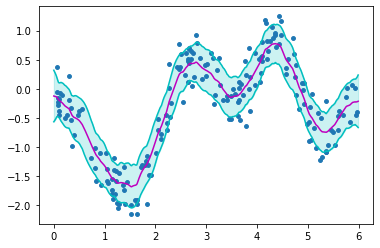

100
kernel lengthscale: 0.89
kernel variance: 0.35
Exact model log p(y): -155.90


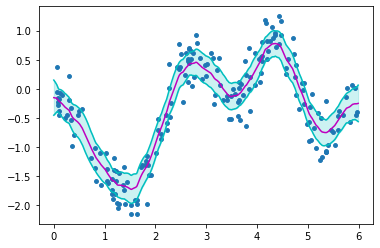

200
kernel lengthscale: 1.20
kernel variance: 0.39
Exact model log p(y): -100.44


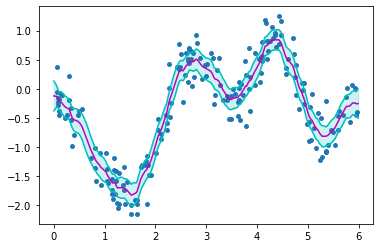

300
kernel lengthscale: 1.42
kernel variance: 0.44
Exact model log p(y): -73.39


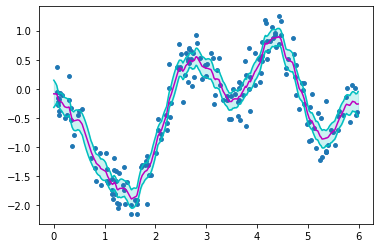

400
kernel lengthscale: 1.55
kernel variance: 0.51
Exact model log p(y): -68.61


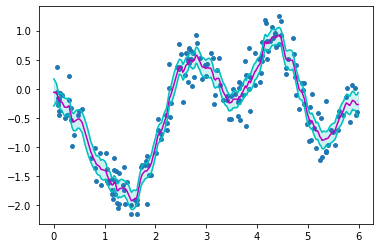

Exact model log p(y): -68.32


In [11]:

kernel = gpflow.kernels.Matern12(variance=0.5, lengthscales=0.5)
likelihood = gpflow.likelihoods.Gaussian()

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, True)
gpflow.utilities.set_trainable(kernel.variance, True)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_closure():
  return -exactModel.log_marginal_likelihood()

Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

for i in range(500):
  if i % 100 == 0:
    print(i)
    print("kernel lengthscale: %2.2f" % kernel.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel.variance.read_value())
    print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

    mean, std = exactModel.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'm', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=exactModel.trainable_variables )

print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

###We now use approximate inference with Random Variational Fourier Features

kernel lengthscale: 0.70
kernel variance: 1.00
ELBO: -219.81


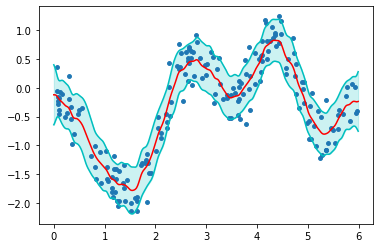

kernel lengthscale: 0.80
kernel variance: 0.88
ELBO: -207.18


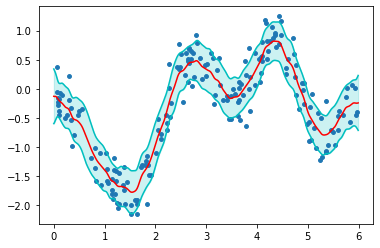

kernel lengthscale: 0.91
kernel variance: 0.77
ELBO: -194.39


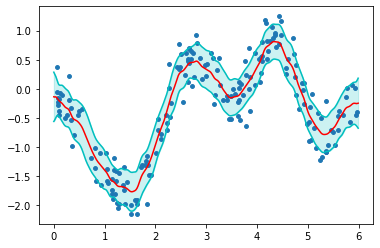

kernel lengthscale: 1.01
kernel variance: 0.68
ELBO: -181.48


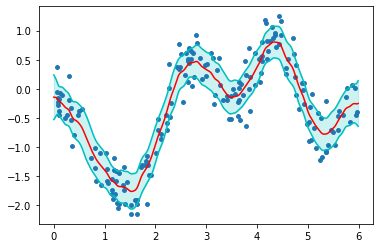

kernel lengthscale: 1.11
kernel variance: 0.61
ELBO: -168.57


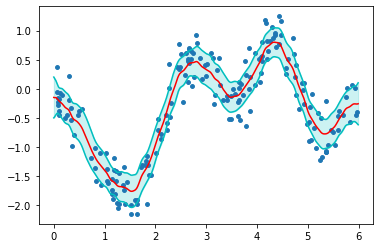

kernel lengthscale: 1.19
kernel variance: 0.55
ELBO: -155.79


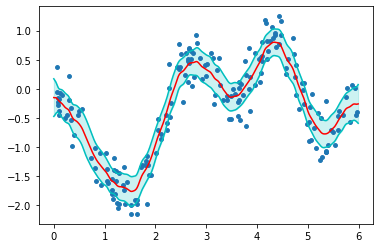

kernel lengthscale: 1.26
kernel variance: 0.50
ELBO: -143.31


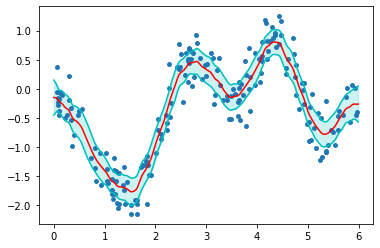

kernel lengthscale: 1.32
kernel variance: 0.48
ELBO: -131.35


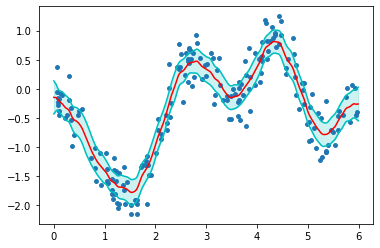

kernel lengthscale: 1.37
kernel variance: 0.46
ELBO: -120.11


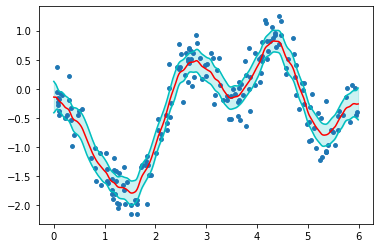

kernel lengthscale: 1.41
kernel variance: 0.44
ELBO: -109.84


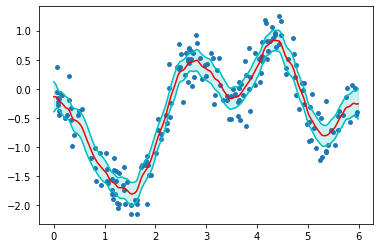

kernel lengthscale: 1.44
kernel variance: 0.44
ELBO: -100.78


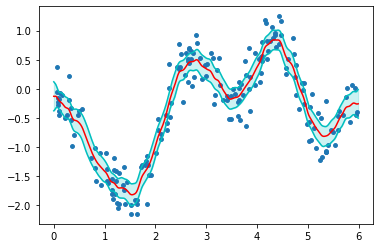

kernel lengthscale: 1.48
kernel variance: 0.43
ELBO: -93.10


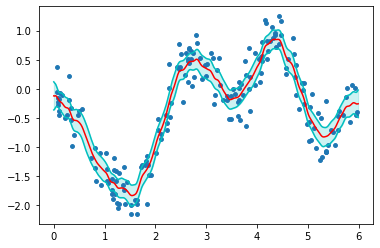

kernel lengthscale: 1.51
kernel variance: 0.43
ELBO: -86.86


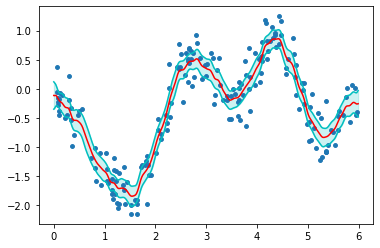

kernel lengthscale: 1.54
kernel variance: 0.43
ELBO: -82.07


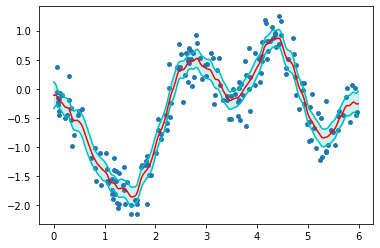

kernel lengthscale: 1.57
kernel variance: 0.43
ELBO: -78.60


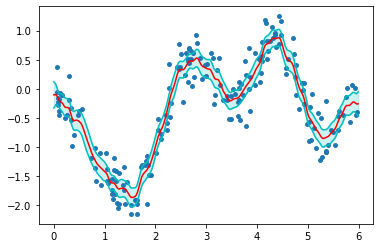

kernel lengthscale: 1.60
kernel variance: 0.43
ELBO: -76.25


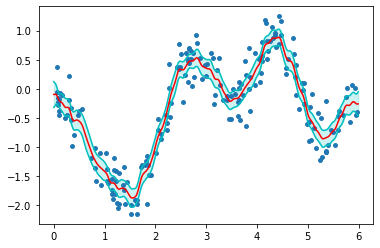

kernel lengthscale: 1.63
kernel variance: 0.43
ELBO: -74.73


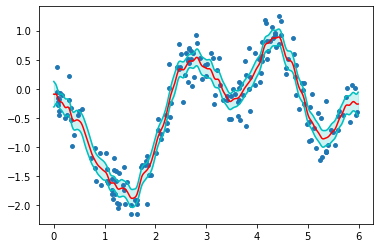

kernel lengthscale: 1.65
kernel variance: 0.44
ELBO: -73.85


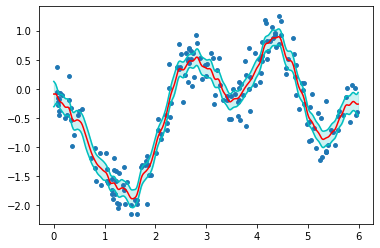

kernel lengthscale: 1.67
kernel variance: 0.44
ELBO: -73.34


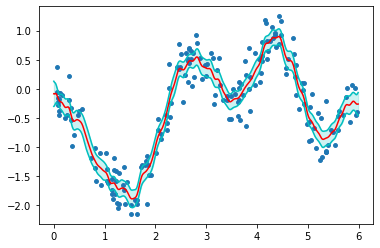

kernel lengthscale: 1.70
kernel variance: 0.44
ELBO: -73.06


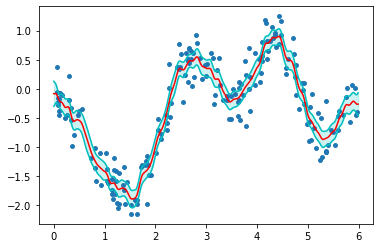

kernel lengthscale: 1.72
kernel variance: 0.45
ELBO: -72.92


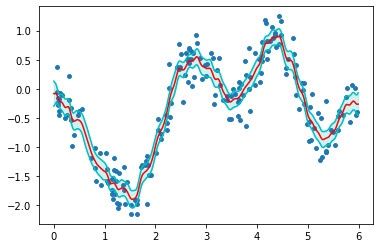

kernel lengthscale: 1.74
kernel variance: 0.45
ELBO: -72.86


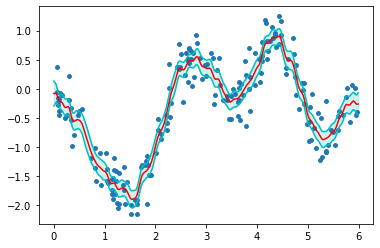

kernel lengthscale: 1.76
kernel variance: 0.46
ELBO: -72.82


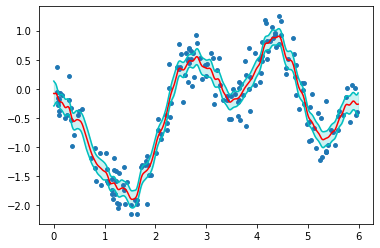

kernel lengthscale: 1.78
kernel variance: 0.46
ELBO: -72.82


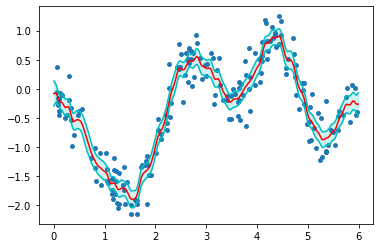

kernel lengthscale: 1.79
kernel variance: 0.47
ELBO: -72.79


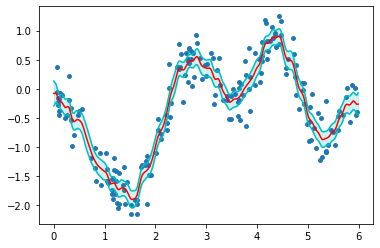

kernel lengthscale: 1.81
kernel variance: 0.47
ELBO: -72.81


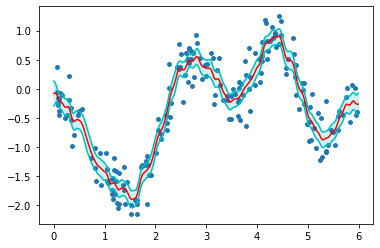

kernel lengthscale: 1.83
kernel variance: 0.48
ELBO: -72.79


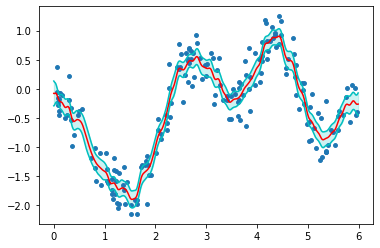

kernel lengthscale: 1.84
kernel variance: 0.48
ELBO: -72.77


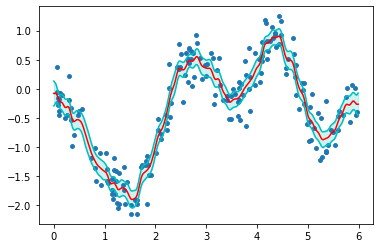

kernel lengthscale: 1.86
kernel variance: 0.48
ELBO: -72.77


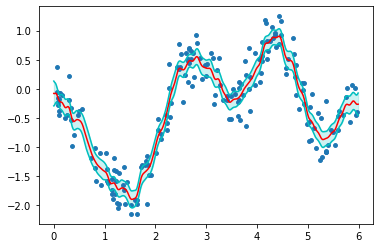

kernel lengthscale: 1.87
kernel variance: 0.49
ELBO: -72.74


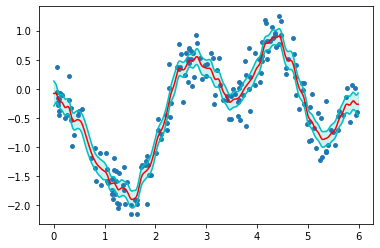

kernel lengthscale: 1.89
kernel variance: 0.49
ELBO: -72.77


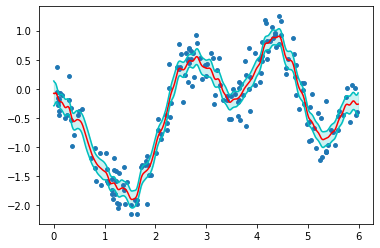

kernel lengthscale: 1.90
kernel variance: 0.49
ELBO: -72.75


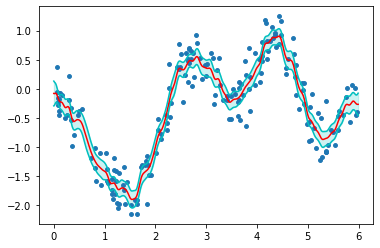

kernel lengthscale: 1.92
kernel variance: 0.50
ELBO: -72.73


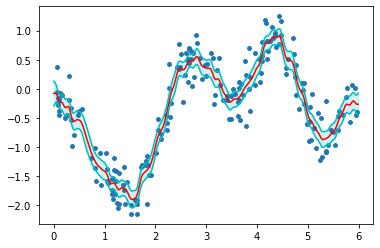

kernel lengthscale: 1.93
kernel variance: 0.50
ELBO: -72.73


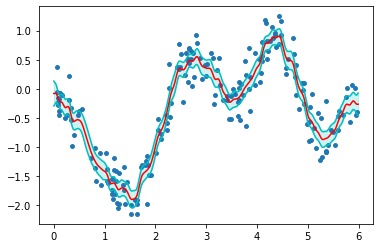

kernel lengthscale: 1.94
kernel variance: 0.50
ELBO: -72.73


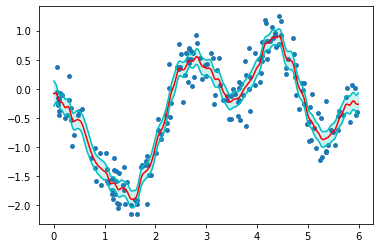

kernel lengthscale: 1.95
kernel variance: 0.51
ELBO: -72.73


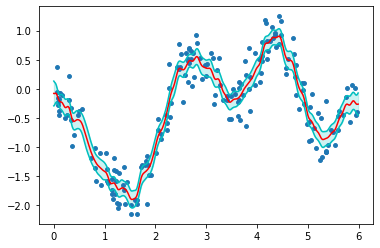

kernel lengthscale: 1.96
kernel variance: 0.51
ELBO: -72.73


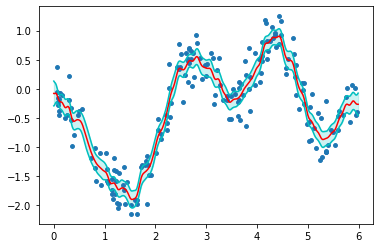

kernel lengthscale: 1.97
kernel variance: 0.51
ELBO: -72.75


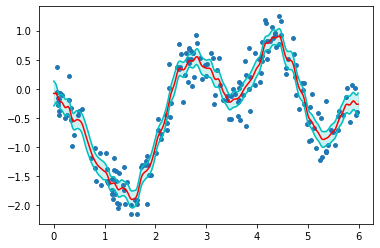

kernel lengthscale: 1.98
kernel variance: 0.51
ELBO: -72.73


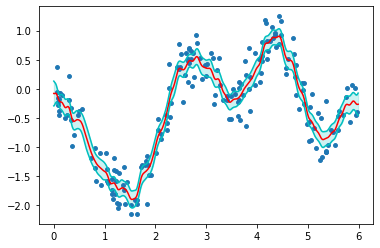

kernel lengthscale: 1.99
kernel variance: 0.52
ELBO: -72.75


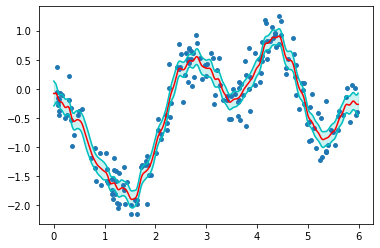

kernel lengthscale: 2.00
kernel variance: 0.52
ELBO: -72.73


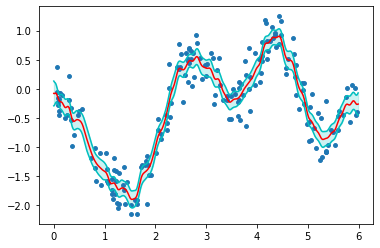

kernel lengthscale: 2.01
kernel variance: 0.52
ELBO: -72.70


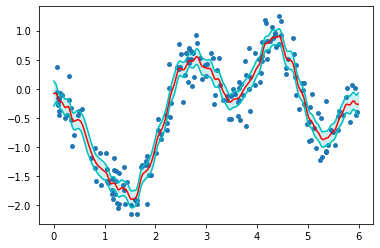

kernel lengthscale: 2.02
kernel variance: 0.52
ELBO: -72.72


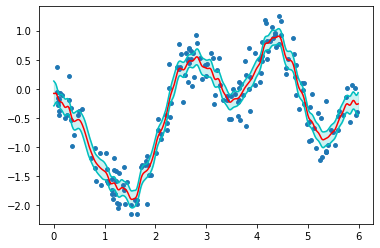

kernel lengthscale: 2.03
kernel variance: 0.52
ELBO: -72.64


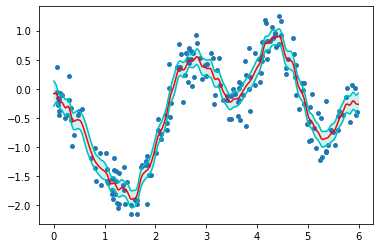

kernel lengthscale: 2.04
kernel variance: 0.53
ELBO: -72.63


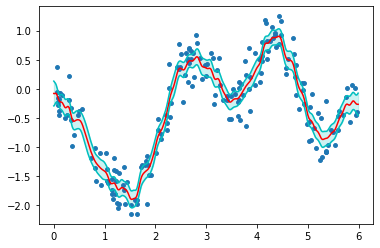

kernel lengthscale: 2.04
kernel variance: 0.53
ELBO: -72.64


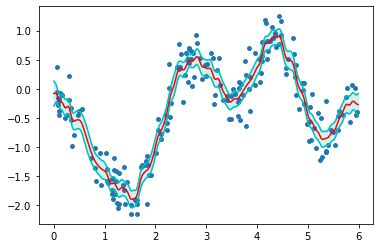

kernel lengthscale: 2.05
kernel variance: 0.53
ELBO: -72.62


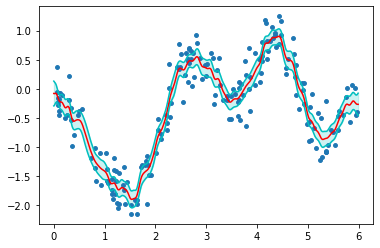

kernel lengthscale: 2.06
kernel variance: 0.53
ELBO: -72.62


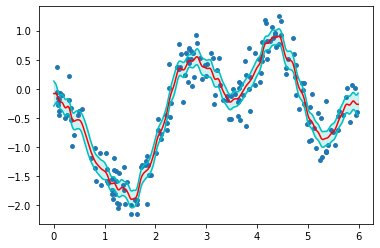

kernel lengthscale: 2.06
kernel variance: 0.53
ELBO: -72.63


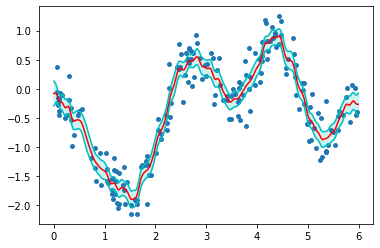

kernel lengthscale: 2.07
kernel variance: 0.54
ELBO: -72.62


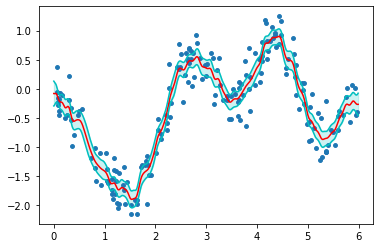

Variational Model ELBO is -72.63


In [67]:
tf.config.experimental_run_functions_eagerly(True)

M = 100
inducing_variable = RVFF_1D( a=0, b=6, M=M )

kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel2, inducing_variable=inducing_variable
)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

gpflow.set_trainable(kernel2.variance, True)
gpflow.set_trainable(kernel2.lengthscales, True)
gpflow.set_trainable(model.likelihood, True)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, True)
gpflow.set_trainable(model.inducing_variable.omegas, True)

@tf.function
def loss_closure():
  return -model.elbo()

# Compute the gradients for a list of variables.
# with tf.GradientTape() as tape:
#   loss = loss_closure()
# var_list = model.trainable_parameters
# grads = tape.gradient(loss, var_list)

# print(grads)

# Ask the optimizer to apply the processed gradients.
# optimizer.apply_gradients(zip(grads, var_list))

for i in range(1000):
  if i % 20 == 0:
    print("kernel lengthscale: %2.2f" % kernel2.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel2.variance.read_value())
    print("ELBO: %2.2f" % model.elbo() )

    mean, std = model.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'r', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

print( "Variational Model ELBO is %3.2f" % model.elbo() )

#Testing

###Plotting a posterior sample on top of the scatter plot of the data:

In [0]:
with open('./model', 'wb') as fp:
    pickle.dump(model.trainable_parameters, fp)
    pickle.dump(inducing_variable.omegas, fp)
    pickle.dump(inducing_variable.phis, fp)
    pickle.dump(model.likelihood.variance, fp)

In [0]:
with open('./model', 'rb') as fp:
    param_dict = pickle.load(fp)
    omegas = pickle.load(fp)
    phis = pickle.load(fp)
    likelihoodVariance = pickle.load(fp)

inducing_variable = RVFF_1D( a=0, b=6, M=M )
inducing_variable.omegas = omegas
inducing_variable.phis = phis

model = gpflow.models.SGPR((X, Y), kernel=kernel, inducing_variable=inducing_variable)
model.likelihood.variance = likelihoodVariance

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)
gpflow.utilities.set_trainable(inducing_variable.a, False)
gpflow.utilities.set_trainable(inducing_variable.b, False)

if len(model.trainable_parameters) == len(param_dict):
  for i in range(len(model.trainable_parameters)):
    model.trainable_parameters[i].assign(param_dict[i])

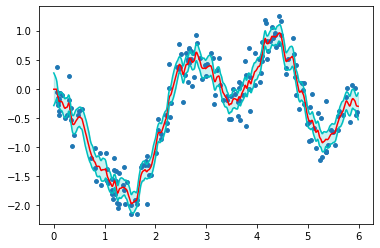

ELBO of SGPR model is -74.88
log( p( Y | θ ) ) of exact GP is -68.32


In [29]:
mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print("ELBO of SGPR model is %4.2f" % model.elbo().numpy())
print("log( p( Y | θ ) ) of exact GP is %4.2f" % exactModel.log_marginal_likelihood().numpy())

Testing whether the model is the equivalent to Variational Fourier Features when the frequencies and phases are set manually to correspond to multiples of the base frequency, and not optimised as variational parameters. 

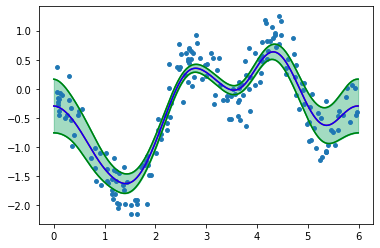

If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.
RVFF model ELBO is -225.42
VFF model ELBO is -225.42
Test failed.


In [30]:
def testFeatureequivalence(tol):
  VFFlength = 10
  RVFFlength = 2 * VFFlength - 1

  VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel2, VFFinducingVar)

  RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)

  RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
  RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
  RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

  RVFFinducingVar.omegas.assign( RVFFfrequencies )
  RVFFinducingVar.phis.assign( RVFFphases )

  RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)
    
  meanVFF, covVFF = VFFmodel.predict_f(Xtest, True, False)
  meanRVFF, covRVFF = RVFFmodel.predict_f(Xtest, True, False)
  
  plot(Xtest, [(meanVFF, tf.transpose(tf.linalg.diag_part(covVFF)), 'r', 'c'), (meanRVFF, tf.transpose(tf.linalg.diag_part(covRVFF)), 'b', 'g')])
  print("If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.")

  print("RVFF model ELBO is %2.2f" % RVFFmodel.elbo())
  print("VFF model ELBO is %2.2f" % VFFmodel.elbo())

  return tf.math.reduce_sum(tf.math.abs(covRVFF-covVFF)) < tol and tf.math.reduce_sum(tf.math.abs(meanRVFF-meanVFF)) < tol

str = "Test passed!" if testFeatureequivalence(10e-2) else "Test failed."
print(str)

Testing whether $q(u) = p(u)$ when we fix q_sqrt = cholesky($K_{uu}$)

In [31]:
kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)
likelihood = gpflow.likelihoods.Gaussian()

M = 200

inducing_variable = RVFF_1D( a=0, b=6, M=M )

def testPriorEqualsPosterior():
  M = 200
  model = gpflow.models.SVGP(
      kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
  )
  q_sqrt = tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) )

  return model.prior_kl()

print( "KL[ q(u) | p(u) ] = %2.3f" % testPriorEqualsPosterior() )

KL[ q(u) | p(u) ] = 0.000


Testing whether $K_{uu}$ is computed correctly with Monte-Carlo integration:

In [32]:
def grid_search_integrate(f, bound1, bound2, numOfSamples):
  samples = tf.range(bound1, bound2, ( bound2 - bound1 ) / float(numOfSamples))
  V = tf.math.reduce_prod( bound2 - bound1 )

  return V * tf.math.reduce_sum( f( samples ) ) / numOfSamples

def mattern_half_inner_product_integrand(frnel lengthscale: 0.70
Kernel variance: 1.00
Model lik
    return ( lambda_ * f(x) + df(x) ) * ( lambda_ * g(x) + dg(x) )
  return evaluate_on

def grid_search_mattern_half_inner_prod( sigma, lambda_, a, b, omega1, phi1, omega2, phi2 ):
  f = sin(omega1, a, phi1)
  g = sin(omega2, a, phi2)
  
  df = dsin(omega1, a, phi1)
  dg = dsin(omega2, a, phi2)

  integral = grid_search_integrate(
      mattern_half_inner_product_integrand(f, g, df, dg, lambda_),
      a,
      b,
      10e6
  )

  term1 = integral / ( 2 * lambda_ * sigma * sigma )
  term2 = f(a) * g(a) / (sigma * sigma)

  return term1 + term2

def sin( omega, a, phi ):
  def compute_sin(x):
    return tf.sin( omega * ( x - a + phi ) )
  return compute_sin

def dsin( omega, a, phi ):
  def compute_dsin(x):
    return omega * tf.cos( omega * ( x - a + phi ) )
  return compute_dsin

def test_Kuu_evaluation(inducing_variable, kernel, tol):
  analyticKuu = gpflow.covariances.Kuu(inducing_variable, kernel)
  numericalKuu = np.empty((len(inducing_variable), len(inducing_variable)))

  a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis)) (inducing_variable)  
  lambda_, sigma = (lambda k: (1/k.lengthscales, k.variance))(kernel)

  for i in range(len(inducing_variable)):
    for j in range(len(inducing_variable)):
      numericalKuu[i, j] = grid_search_mattern_half_inner_prod(sigma, lambda_, a, b, omegas[i], phis[i], omegas[j], phis[j])

  print(analyticKuu)
  print(numericalKuu)

  return True if tf.reduce_all( abs(analyticKuu - numericalKuu) < tol ) else False

str = "Test passed!" if test_Kuu_evaluation(RVFF_1D(0, 6, 2), gpflow.kernels.Matern12(), 10e-3) else "Test failed."
print(str)

tf.Tensor(
[[ 1.03809005e+03 -9.22546736e+00]
 [-9.22546736e+00  3.34946850e+04]], shape=(2, 2), dtype=float64)
[[ 1.03809007e+03 -9.22552525e+00]
 [-9.22552525e+00  3.34946837e+04]]
Test passed!


Testing whether the predictive covariance $K_{ff}$ is positive semidefinite.

In [33]:
def is_psd(matrix, tol):
  return tf.reduce_all(tf.linalg.eigh(matrix)[0] > tol)

def test_predictive_cov_is_psd(model):
  Xtest = np.arange(0, 6, 0.05).reshape(-1, 1)
  predictive_cov = tf.squeeze( model.predict_f(X, True, False)[1] )
  return is_psd(predictive_cov, -1e-1)

str = "True" if test_predictive_cov_is_psd(model) else "False"
print( "predictive_cov is psd: " + str )

predictive_cov is psd: True


# Feature comparison with Variational Fourier Features


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -229.80


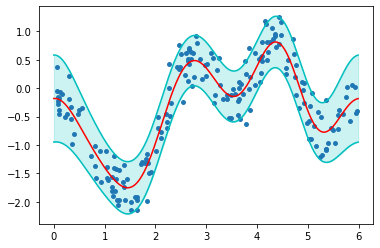

Iteration 20
Kernel lengthscale: 1.27
Kernel variance: 0.23
Model likelihood variance: 0.21
Model ELBO: -117.61


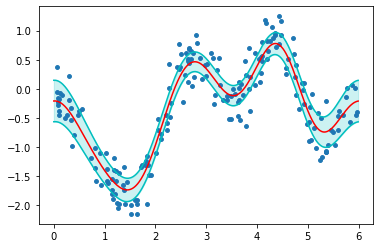


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -229.80


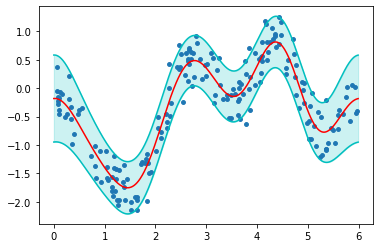

Iteration 20
Kernel lengthscale: 1.69
Kernel variance: 0.19
Model likelihood variance: 0.11
Model ELBO: -106.21


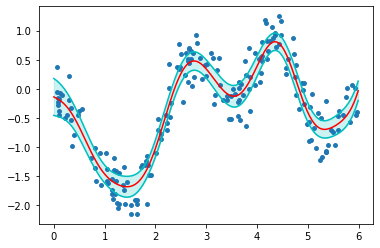


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -232.53


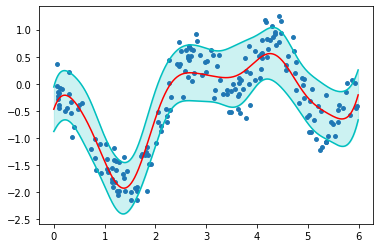

Iteration 20
Kernel lengthscale: 2.10
Kernel variance: 0.27
Model likelihood variance: 0.07
Model ELBO: -102.47


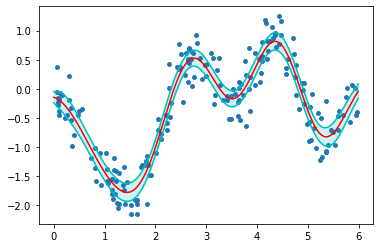


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -226.59


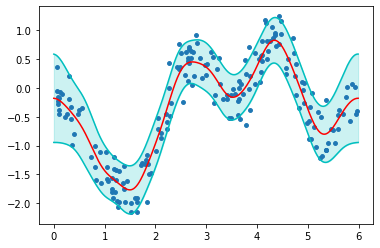

Iteration 20
Kernel lengthscale: 0.59
Kernel variance: 0.10
Model likelihood variance: 0.06
Model ELBO: -111.45


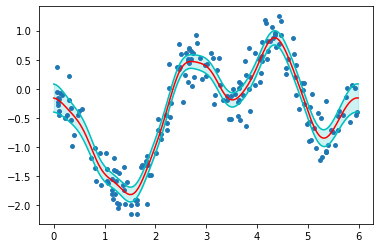


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -226.59


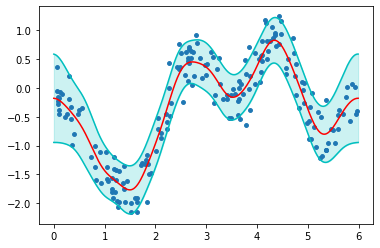

Iteration 20
Kernel lengthscale: 0.50
Kernel variance: 0.13
Model likelihood variance: 0.10
Model ELBO: -138.00


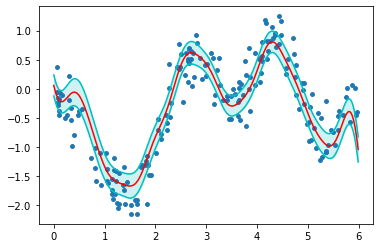


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -221.94


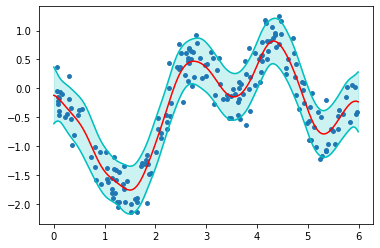

Iteration 20
Kernel lengthscale: 2.47
Kernel variance: 0.31
Model likelihood variance: 0.07
Model ELBO: -92.47


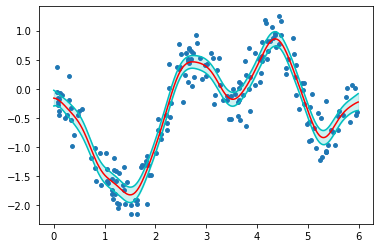


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -225.83


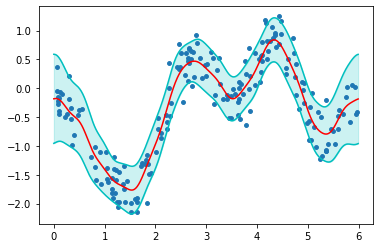

Iteration 20
Kernel lengthscale: 0.79
Kernel variance: 0.13
Model likelihood variance: 0.08
Model ELBO: -96.32


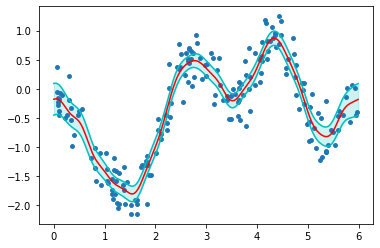


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -225.83


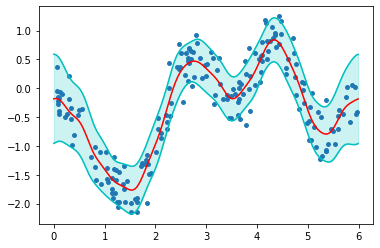

Iteration 20
Kernel lengthscale: 0.44
Kernel variance: 0.10
Model likelihood variance: 0.10
Model ELBO: -100.70


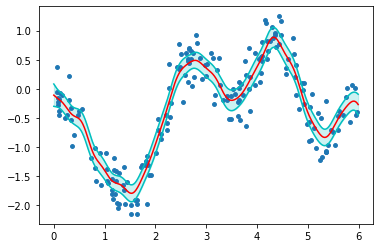


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -231.10


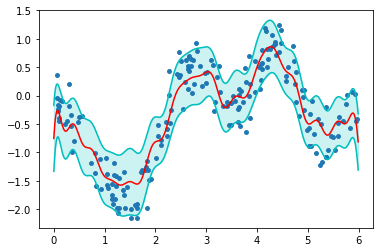

Iteration 20
Kernel lengthscale: 0.37
Kernel variance: 0.10
Model likelihood variance: 0.13
Model ELBO: -121.24


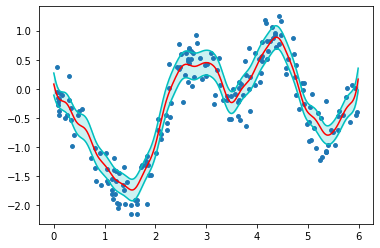


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -225.47


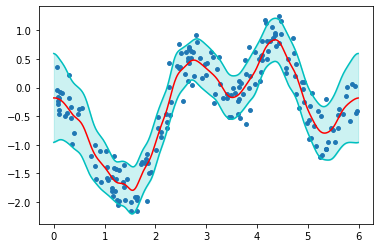

Iteration 20
Kernel lengthscale: 0.80
Kernel variance: 0.16
Model likelihood variance: 0.11
Model ELBO: -93.14


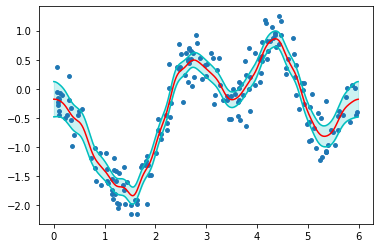


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -225.47


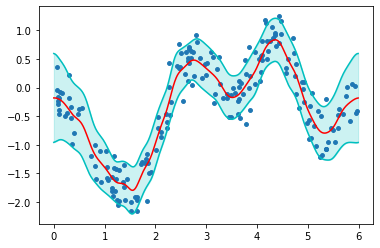

Iteration 20
Kernel lengthscale: 0.47
Kernel variance: 0.12
Model likelihood variance: 0.13
Model ELBO: -111.56


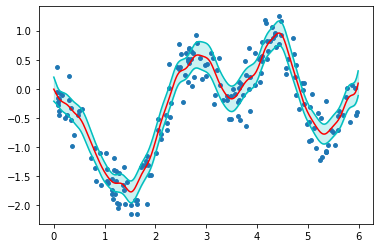


====================== TRAINING NEW MODEL ==========================

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
Model likelihood variance: 1.00
Model ELBO: -236.22


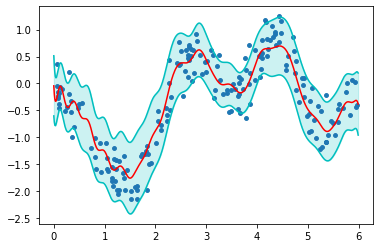

Iteration 20
Kernel lengthscale: 0.61
Kernel variance: 0.15
Model likelihood variance: 0.12
Model ELBO: -88.86


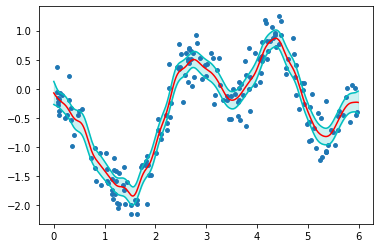

4


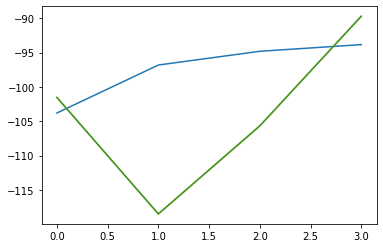

In [88]:
def getModels(numBasisFunctions):

  if numBasisFunctions % 2 != 1:
    return

  kernel1 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
  kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
  kernel3 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

  # ==============================================================
  # VFF model setup:
  VFFlength = int(( numBasisFunctions + 1 ) / 2)
  VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel1, VFFinducingVar)
  # ==============================================================

  # ==============================================================
  # RVFF model setup, with orthogonal initial basis functions
  RVFFlength = numBasisFunctions #2 * VFFlength - 1

  RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
  RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
  RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

  RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)
  RVFFinducingVar.omegas.assign( RVFFfrequencies )
  RVFFinducingVar.phis.assign( RVFFphases )

  RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)
  # ==============================================================

  # ==============================================================
  # RVFF model, with randomly initialised frequencies:
  inducing_variable = RVFF_1D( a=0, b=6, M=RVFFlength )

  RVFFmodel2 = gpflow.models.SGPR( (X, Y), kernel=kernel3, inducing_variable=inducing_variable )
  # ==============================================================

  # ==============================================================
  # Trainable parameters setup:
  gpflow.set_trainable(kernel1, True)
  gpflow.set_trainable(kernel2, True)
  gpflow.set_trainable(kernel3, True)

  gpflow.set_trainable(VFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(VFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(VFFmodel.likelihood, True)

  gpflow.set_trainable(RVFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(RVFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(RVFFmodel.inducing_variable.phis, True)
  gpflow.set_trainable(RVFFmodel.inducing_variable.omegas, True)
  gpflow.set_trainable(RVFFmodel.likelihood, True)

  gpflow.set_trainable(RVFFmodel2.inducing_variable.a, False)
  gpflow.set_trainable(RVFFmodel2.inducing_variable.b, False)
  gpflow.set_trainable(RVFFmodel2.inducing_variable.phis, True)
  gpflow.set_trainable(RVFFmodel2.inducing_variable.omegas, True)
  gpflow.set_trainable(RVFFmodel2.likelihood, True)
  # ==============================================================

  return VFFmodel, RVFFmodel, RVFFmodel2

# ==============================================================
# Loss function:
@tf.function
def loss(model):
  def loss_closure():
    return -model.elbo()
  return loss_closure
# ==============================================================

optimizer = tf.optimizers.Adam(learning_rate=0.1)

def train(model):

  print("\n===================================================================")
  print("====================== TRAINING NEW MODEL ==========================")
  print("===================================================================\n")
  for i in range(40):
    if i % 20 == 0:
      print("Iteration %2d" % i)
      print("Kernel lengthscale: %2.2f" % model.kernel.lengthscales.read_value() )
      print("Kernel variance: %2.2f" % model.kernel.variance.read_value() )
      print("Model likelihood variance: %2.2f" % model.likelihood.variance.read_value() )
      print("Model ELBO: %2.2f" % model.elbo() )

      mean, std = model.predict_f(Xtest, False, False)
      std = tf.sqrt(std)
      plot(Xtest, [(mean, std, 'r', 'c')])

    optimizer.minimize( loss=loss(model), var_list=model.trainable_variables )

  return model.elbo().numpy()

def transposeListOfLists(l):
  l = np.array(l)
  l = l.T
  return l.tolist()

numOfBasis = list(np.arange(11, 42, 10))
elbos = []

for length in numOfBasis:
  models = getModels(length)
  currentELBOS = []
  elbos.append(currentELBOS)
  for model in models:
    currentELBOS.append(train(model))

elbos = transposeListOfLists(elbos)

VFFelbos = elbos[0]
RVFFelbos = elbos[1]
RVFFelbos2 = elbos[1]

print(len(VFFelbos))

plt.plot(VFFelbos)
plt.plot(RVFFelbos)
plt.plot(RVFFelbos2)

plt.show()

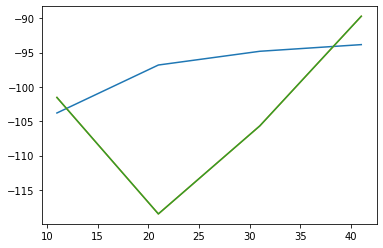

tf.Tensor(
[ -8.00812676  -8.30998371 -15.67991298  -3.62768381 -14.25414286
  -4.26618087   2.12855012  -4.20813096   6.59703758 -16.11111095
   8.26377606   0.10896642   7.52728218   4.84799394   9.4602625
  -3.93048134  11.09597134   1.63384222  10.66873336   6.60781316
  10.9258675    3.23818144  -2.62631605  -8.76004924 -11.22401513
  -3.47399193  -4.46511487  -5.52194219   8.36642532 -13.48371579
   7.03540869  -3.9124489  -10.29618857  -5.34344471  14.34029995
   1.50909868  19.78815802  14.30741554   0.04423633   3.8459649
   1.61060761], shape=(41,), dtype=float64)


In [93]:
plt.plot(numOfBasis, VFFelbos)
plt.plot(numOfBasis, RVFFelbos)
plt.plot(numOfBasis, RVFFelbos2)

plt.show()

RVFFmodel = models[1]
RVFFmodel2 = models[2]

print(RVFFmodel.inducing_variable.omegas-RVFFmodel2.inducing_variable.omegas)
# print(RVFFmodel2.inducing_variable.omegas)

# print(VFFelbos)
# print(RVFFelbos)
# print(RVFFelbos2)